In [10]:
import os
import pandas as pd
import numpy as np
import cv2
import seaborn as sns

C:\Users\ACER\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
# sns.set(rc={'figure.figsize':(11.7,8.27)})

In [6]:
IMAGE_PATH = './data/raw/trainset'
LABEL_PATH = './data/raw'

DATA_PATH = './data/processed/dataset'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


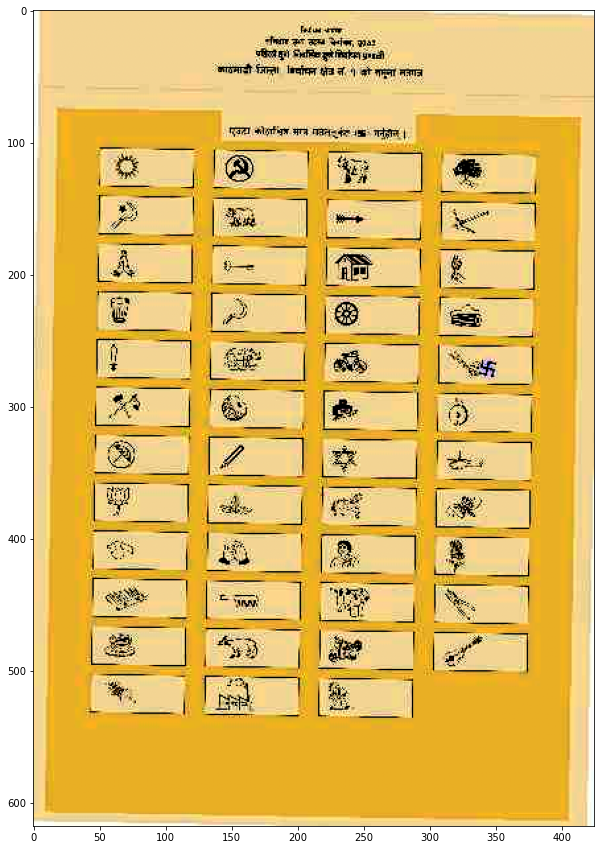

True

In [4]:

image = cv2.imread(os.path.join(IMAGE_PATH, '100007.jpeg'))

image = (image / 127.5) - 1
plt.imshow(image)
plt.show()

cv2.imwrite('preview.png', image)

In [5]:
df = pd.read_csv(os.path.join(LABEL_PATH, 'trainset.csv'))

In [6]:
df.head()

,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10


In [7]:
df.shape

(9600, 2)

In [7]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np


In [ ]:
def process_data(data_dir, output_dir, size=(150, 150)):
    
    images = []
    labels = []
    
    for filename in df['Data'].values:
        save_path = os.path.join(output_dir, str(df[df['Data'] == filename]['Label'].values[0]))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        img = cv2.imread(os.path.join(data_dir, filename))
        if img is not None:
            img = cv2.resize(img, size)
            
            
            p = os.path.join(save_path, filename)
            cv2.imwrite(p, img)

    

In [ ]:
process_data(IMAGE_PATH, DATA_PATH)

In [ ]:
lens = {}

for dir in listdir(DATA_PATH):
    lens[dir] = len(listdir(os.path.join(DATA_PATH, dir)))
        

In [ ]:
import seaborn as sns

sns.barplot(x = list(lens.keys()), y = list(lens.values()))

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [ ]:
def img_scale(img):
    img= (img / 127.5) - 1
    return img

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=img_scale,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')



In [ ]:
# img = load_img(os.path.join(IMAGE_PATH, '100007.jpeg'))  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = (x / 127.5) - 1
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, shuffle=False):
#     print(batch)

In [ ]:
AUG_PATH = './data/processed/augmented'

In [ ]:
for i in range(1, 48):
    os.makedirs(os.path.join(AUG_PATH, str(i)))

In [ ]:
for d in listdir(DATA_PATH):
    for img in listdir(os.path.join(DATA_PATH, d)): 
        im = load_img(os.path.join(DATA_PATH, d, img))
        x = img_to_array(im)
#         x= (x / 127.5) - 1
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=os.path.join(AUG_PATH, d), save_prefix='aug', save_format='jpeg'):
            i += 1
            if i > 2:
                break
            
    

In [ ]:
lens = {}

for dir in listdir(AUG_PATH):
    lens[dir] = len(listdir(os.path.join(AUG_PATH, dir)))
        
        
sns.barplot(x = list(lens.keys()), y = list(lens.values()))

In [8]:

def load_images_from_folder(path):
    images = []
    labels = []
    for folder in listdir(path):
        for image in listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, image))
            images.append(img)
            labels.append(asarray(os.path.basename(os.path.join(path, folder))))
    return asarray(images), asarray(labels)

In [13]:
images, labels = load_images_from_folder('./data/processed/testset')

In [12]:
images.shape

(9626, 150, 150, 3)

In [13]:
labels

array(['0', '0', '0', ..., '9', '9', '9'], dtype='<U2')

In [14]:
rescaled_images = []


In [15]:
for img in images:
    img = (img / 127.5) - 1
    rescaled_images.append(img)
    
    

In [18]:
rescaled_images = asarray(rescaled_images)
rescaled_images.shape

(9626, 150, 150, 3)

In [14]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoded_labels = encoder.fit_transform(labels)

In [16]:
import pickle

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
np.savez('dataset_300_300.npz', X=images, y=encoded_labels)

In [ ]:
dataset = np.load('dataset_300_300.npz')

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [60]:
model = None

In [61]:

# model = VGG16(include_top=False, input_shape=(150, 150, 3))
model = ResNet50(include_top=False, input_shape=(150, 150, 3))

for layer in model.layers:
    layer.trainable = False

In [62]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [63]:
model.outputs[0]

<tf.Tensor 'conv5_block3_out_2/Identity:0' shape=(None, 5, 5, 2048) dtype=float32>

In [55]:
X = images # dataset['X']
y = encoded_labels #dataset['y']

In [64]:

flat1 = Flatten()(model.outputs[0])
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(y.shape[1], activation='softmax')(class1)

model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [65]:
from tensorflow.keras.optimizers import RMSprop

In [66]:
opt = RMSprop(0.0001, decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, test_size=0.3)

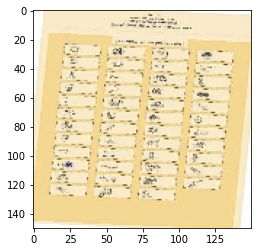

In [58]:
plt.imshow(X_train[0])

In [ ]:
# np.savez('data_150.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [ ]:
# flow = datagen.flow(X_train, y_train, batch_size=16, shuffle=True)

In [67]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
t_board = tf.keras.callbacks.TensorBoard(log_dir="./logs", profile_batch = 100000000)

In [68]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping, t_board], validation_data=(X_test, y_test))

Train on 6738 samples, validate on 2888 samples
Epoch 1/100
6738/6738 [==============================] - 23s 3ms/sample - loss: 3.7691 - accuracy: 0.1634 - val_loss: 5.1054 - val_accuracy: 0.0187
Epoch 2/100
6738/6738 [==============================] - 20s 3ms/sample - loss: 1.9185 - accuracy: 0.4521 - val_loss: 6.3099 - val_accuracy: 0.0204
Epoch 3/100
6738/6738 [==============================] - 20s 3ms/sample - loss: 1.2899 - accuracy: 0.6211 - val_loss: 6.6183 - val_accuracy: 0.0329
Epoch 4/100
6738/6738 [==============================] - 20s 3ms/sample - loss: 0.9944 - accuracy: 0.7045 - val_loss: 6.9493 - val_accuracy: 0.0325


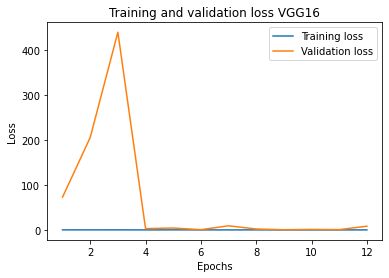

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [2]:
import tensorflow as tf

model = tf.keras.models.load_model('./api/model.h5')

In [76]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [109]:
explanation = explainer.explain_instance(images[44], 
                                         classifier_fn = model.predict, 
                                         top_labels=10, num_samples=1000, segmentation_fn=segmenter)

In [110]:
labels[44]

'1'

In [111]:
from skimage.segmentation import mark_boundaries
import skimage
from skimage.color import gray2rgb, rgb2gray, label2rgb

Text(0.5, 1.0, 'Positive/Negative Regions for 1')

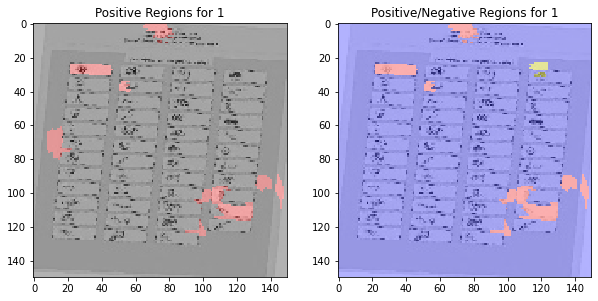

In [113]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(explanation.top_labels[0]))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(explanation.top_labels[0]))

In [117]:
cv2.imwrite('neg.png', label2rgb(3-mask,temp, bg_label = 0)*255)

True